In [1]:
#Inportar Programas#
import bempp.api
import numpy as np 

In [2]:
#Datos Principales. 
R = 2
Ref = 0.300

Q= np.array([1.0,1.0,0.75]) #Carga y posicion
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])
w = 0.150 #kappa
es=80  #[-]
em=4.   #[-]

ec=1.602176e-19 #[C]
kb=1.380648e-23 #[J/K]
T=300 #[K]
S1= 1 #(ec/(kb*T))  #38.681 [C/J]

In [3]:
#Generar la malla de la Esfera#
grid = bempp.api.shapes.sphere(R, (0,0,0), Ref)

In [4]:
#Generar espacios de funcionales de Fem y Bem#
dirichl_space = bempp.api.function_space(grid, "DP", 0)  #u
neumann_space = bempp.api.function_space(grid, "DP", 0)  #du/dn

print("DS dofs: {0}".format(dirichl_space.global_dof_count))
print("NS dofs: {0}".format(neumann_space.global_dof_count))
print("Density: %1.4f"%(neumann_space.global_dof_count/(4*np.pi*R**2)))

DS dofs: 1564
NS dofs: 1564
Density: 31.1148


In [5]:
#Generar operadores de frontera#
#Dominio Um(Adentro)#
id_op = bempp.api.operators.boundary.sparse.identity(dirichl_space, dirichl_space, dirichl_space)
dlpM = bempp.api.operators.boundary.laplace.double_layer(dirichl_space, dirichl_space, dirichl_space) #K
slpM = bempp.api.operators.boundary.laplace.single_layer(neumann_space, dirichl_space, dirichl_space) #V
#Dominio Us(Afuera)#
if w==0:
    dlpS = bempp.api.operators.boundary.laplace.double_layer(dirichl_space, dirichl_space, dirichl_space) #K
    slpS = bempp.api.operators.boundary.laplace.single_layer(neumann_space, dirichl_space, dirichl_space) #V    
else:
    dlpS = bempp.api.operators.boundary.modified_helmholtz.double_layer(dirichl_space, dirichl_space, dirichl_space, w) #K
    slpS = bempp.api.operators.boundary.modified_helmholtz.single_layer(neumann_space, dirichl_space, dirichl_space, w) #V

In [6]:
#Creacion de funciones    
def U_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = (S1 / (4.*np.pi*em))  * np.sum( Q / np.linalg.norm( x - PC, axis=1))
U_c = bempp.api.GridFunction(dirichl_space, fun=U_c)

def dU_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = -(S1/(4.*np.pi*em))   * np.sum( np.dot( x - PC , n)  * Q / (np.linalg.norm( x - PC , axis=1)**3) )
dU_c = bempp.api.GridFunction(neumann_space, fun=dU_c)

Vuc = U_c.projections(dirichl_space)
Vduc = dU_c.projections(neumann_space)

VS1 = ((em/es-1)*(0.5*id_op - dlpS)*U_c).projections(dirichl_space)
A1 = (em/es)*((dlpS - 0.5*id_op)*U_c).projections(dirichl_space)
A2 = -(em/es)*(slpS*dU_c).projections(dirichl_space)

#Construccion matriz derecha#

# EL rhs en FEM
rhs_M = np.zeros(dirichl_space.global_dof_count)
# El rhs en BEM
rhs_S = VS1 + A1 + A2
# La combinacion de rhs
rhs = np.concatenate([rhs_M, rhs_S])

In [7]:
#Construccion matriz izquierda#
blocks = [[None,None],[None,None]]
 
#Posicion de la matriz 2x2#
B00 = (.5*id_op + dlpM).weak_form()
B01 = -slpM.weak_form()
B10 = (.5*id_op - dlpS).weak_form()
B11 = slpS.weak_form()*(em/es)
blocks[0][0] = B00  #0.5+K
blocks[0][1] = B01  #-V
blocks[1][0] = B10  #0.5-K
blocks[1][1] = B11  #V(em/es)

blocked = bempp.api.BlockedDiscreteOperator(np.array(blocks))

In [8]:
#Calcular la solucion de la Ec. Ax=B#
it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

from scipy.sparse.linalg import gmres
soln, info = gmres(blocked, rhs, M=None, callback=count_iterations,tol=1e-4)  #Sin Precondicionador#

soln_u = soln[:dirichl_space.global_dof_count]
soln_du = soln[dirichl_space.global_dof_count:]

print("Number of iterations: {0}".format(it_count))

Number of iterations: 51


In [9]:
#Calcula todo el dominio de u a partir del borde calculado#

# Calcula el funcion solucion con los datos de Dirichlet en el borde
dirichlet_fun = bempp.api.GridFunction(dirichl_space, coefficients=soln_u)
# Calcula el funcion solucion con los datos de Neumann en el borde
neumann_fun = bempp.api.GridFunction(neumann_space, coefficients=soln_du)
#Caso u_c
dirichlet_uc_fun = U_c
#Caso du_c
neumann_duc_fun = dU_c

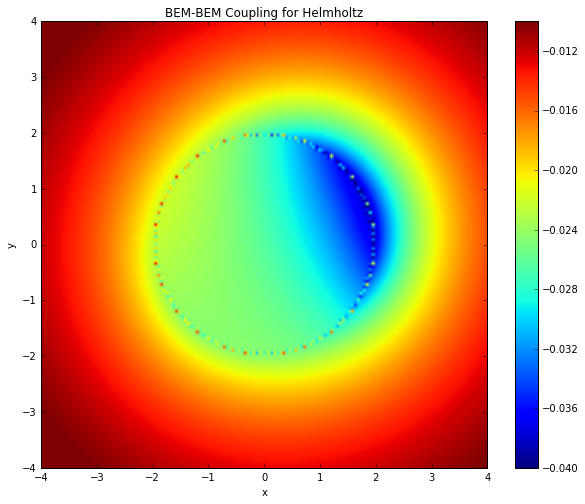

In [10]:
#Graficar solucion#

%matplotlib inline
bempp.api.global_parameters.hmat.eps = 1E-2

Nx=150
Ny=150
Z=0 #Posicion del plano
xmin, xmax, ymin, ymax=[-4,4,-4,4]
plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.array([Z]*plot_grid[0].size)))  #Modificacion del plano#
plot_me = np.zeros(points.shape[1], dtype=np.complex128)

x,y,z = points
us_x = np.logical_not(np.sqrt(x**2+y**2+z**2)<R)

slpM_pot= bempp.api.operators.potential.laplace.single_layer(neumann_space, points[:,np.logical_not(us_x)])
dlpM_pot= bempp.api.operators.potential.laplace.double_layer(dirichl_space, points[:,np.logical_not(us_x)])
if w==0:
    slpS_pot= bempp.api.operators.potential.laplace.single_layer(neumann_space, points[:,us_x])
    dlpS_pot= bempp.api.operators.potential.laplace.double_layer(dirichl_space, points[:,us_x])    
else:
    slpS_pot= bempp.api.operators.potential.modified_helmholtz.single_layer(neumann_space, points[:,us_x], w)
    dlpS_pot= bempp.api.operators.potential.modified_helmholtz.double_layer(dirichl_space, points[:,us_x], w)

#Dominio um#
plot_me[np.logical_not(us_x)] -= dlpM_pot.evaluate(dirichlet_fun).flat
plot_me[np.logical_not(us_x)] += slpM_pot.evaluate(neumann_fun).flat

#Dominio us a partir de um y dum/dn#
plot_me[us_x] += dlpS_pot.evaluate(dirichlet_fun).flat
plot_me[us_x] -= (slpS_pot.evaluate(neumann_fun)*(em/es)).flat
plot_me[us_x] -= (slpS_pot.evaluate(neumann_duc_fun)*(em/es)).flat
plot_me[us_x] += (dlpS_pot.evaluate(dirichlet_uc_fun)).flat

for i in range(len(Q)):
    plot_me[us_x] -= (S1 / (4.*np.pi*em))  * ( Q[i] / np.linalg.norm(np.transpose( points[:,us_x] ) - PC[i], axis=1))

plot_me = plot_me.reshape((Nx, Ny))
plot_me = plot_me.transpose()[::-1]

# Muestra el grafico
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(10, 8))
plt.imshow(np.real(plot_me), extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.clim(-0.010,-0.040)
plt.title("BEM-BEM Coupling for Helmholtz")
plt.show()

In [11]:
#Energia de solvatacion#
slpF = bempp.api.operators.potential.laplace.single_layer(neumann_space, np.transpose(PC)) 
dlpF = bempp.api.operators.potential.laplace.double_layer(dirichl_space, np.transpose(PC))

uF = slpF*neumann_fun - dlpF*dirichlet_fun

E_Solv = 0.5*4.*np.pi*332.064*np.sum(Q*uF).real 
print('Energia de Solvatacion: {:7.2f} [kCal/mol]'.format(E_Solv) )

Energia de Solvatacion: -165.05 [kCal/mol]


In [12]:
#Energia de solvatacion teorica#
from an_solution import an_P
G2 = an_P(Q, PC, em, es, R, w, R , 10)
print(G2)

-164.586330948


In [13]:
#Error absoluto#
Error = np.abs( E_Solv/G2-1 )*100
print(Error)

0.280269343061
